# 東京23区賃貸物件のスクレイピングと分析

# 1.ライブラリのインポート

In [ ]:
import requests
from bs4 import BeautifulSoup
import time
import sqlite3
import pandas as pd
import re
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import japanize_matplotlib
sns.set(style="whitegrid", font="IPAexGothic")

# 2.設定

In [ ]:
headers = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36'
}

# SUUMO設定（東京23区）
base_url = 'https://suumo.jp/jj/chintai/ichiran/FR301FC001/?ar=030&bs=040&ta=13&sc=13101&sc=13102&sc=13103'
db_name = 'suumo_analysis.db'
table_name = 'properties'

print(f"データベース名: {db_name}")
print(f"テーブル名: {table_name}")

# 3.データベースの作成

In [ ]:
try:
    conn = sqlite3.connect(db_name)
    cur = conn.cursor()
    
    # テーブル作成（存在しない場合のみ）
    sql = f'''CREATE TABLE IF NOT EXISTS {table_name} (
        id INTEGER PRIMARY KEY AUTOINCREMENT,
        name TEXT NOT NULL,
        rent REAL,
        station_distance INTEGER,
        area REAL,
        floor_plan TEXT,
        collected_date TEXT
    );'''
    
    cur.execute(sql)
    conn.commit()
    print("✓ データベース接続・テーブル作成完了")
    
except sqlite3.Error as e:
    print(f'✗ エラー: {e}')
finally:
    conn.close()

✓ データベース接続・テーブル作成完了


## 4. スクレイピング関数

In [ ]:
def scrape_suumo(max_pages=3):
    """SUUMOから物件データをスクレイピングする関数"""
    properties = []
    
    print(f"スクレイピング開始（最大{max_pages}ページ）...")
    
    for page in range(1, max_pages + 1):
        url = f"{base_url}&page={page}"
        
        try:
            # サーバー負荷対策
            time.sleep(2)
            
            response = requests.get(url, headers=headers, timeout=10)
            response.raise_for_status()
            
            soup = BeautifulSoup(response.text, 'html.parser')
            items = soup.find_all('div', class_='cassetteitem')
            
            if not items:
                print(f"ページ {page}: データなし（終了）")
                break
                
            print(f"ページ {page}: {len(items)}件の物件を検出")
            
            # 各物件のループ
            for item in items:
                try:
                    # 基本情報
                    name_elem = item.find('div', class_='cassetteitem_content-title')
                    name = name_elem.text.strip() if name_elem else "不明"
                    
                    # 駅距離
                    station_elem = item.find('div', class_='cassetteitem_detail-text')
                    dist_match = re.search(r'歩(\d+)分', station_elem.text) if station_elem else None
                    station_distance = int(dist_match.group(1)) if dist_match else None
                    
                    # 各部屋情報のループ
                    rooms = item.find_all('tbody')
                    for room in rooms:
                        try:
                            # 家賃
                            rent_elem = room.find('span', class_='cassetteitem_price--rent')
                            rent = float(rent_elem.text.replace('万円', '')) if rent_elem else None
                            
                            # 面積
                            area_elem = room.find('span', class_='cassetteitem_menseki')
                            area = float(area_elem.text.replace('m2', '')) if area_elem else None
                            
                            # 間取り
                            floor_elem = room.find('span', class_='cassetteitem_madori')
                            floor_plan = floor_elem.text.strip() if floor_elem else "不明"
                            
                            # 有効なデータのみ追加
                            if rent and station_distance is not None:
                                properties.append({
                                    'name': name,
                                    'rent': rent,
                                    'station_distance': station_distance,
                                    'area': area,
                                    'floor_plan': floor_plan,
                                    'collected_date': datetime.now().strftime('%Y-%m-%d')
                                })
                        except Exception:
                            continue
                            
                except Exception:
                    continue
                    
        except Exception as e:
            print(f"ページ {page} でエラー発生: {e}")
            break
            
    return properties


## 5. データ収集の実行

In [ ]:
# ページ数を指定して実行（例：3ページ）
data = scrape_suumo(max_pages=3)
print(f"\n合計 {len(data)} 件のデータを取得しました。")

# 最初のデータを表示して確認
if len(data) > 0:
    print("データサンプル:", data[0])
else:
    print("警告: データが取得できていません。")


スクレイピング開始（最大5ページ）...
ページ 1: 30件の物件を検出
ページ 2: 30件の物件を検出
ページ 3: 30件の物件を検出
ページ 4: 30件の物件を検出
ページ 5: 30件の物件を検出

合計 951 件のデータを取得しました。
✓ 新規保存: 1件


## 6. データベースへの保存

In [ ]:
if data:
    conn = sqlite3.connect(db_name)
    df = pd.DataFrame(data)
    
    # データを保存（replace=既存データを上書き、append=追加）
    df.to_sql(table_name, conn, if_exists='replace', index=False)
    
    conn.close()
    print("データベースへの保存完了")
    
    # 保存件数の確認
    conn = sqlite3.connect(db_name)
    count = pd.read_sql_query(f"SELECT COUNT(*) FROM {table_name}", conn).iloc[0,0]
    conn.close()
    print(f"現在のDB内のレコード数: {count}件")
else:
    print("保存するデータがありません。")


=== データセット概要 ===
総件数: 1件

基本統計量:
       rent  station_distance  area  age
count   1.0               1.0   1.0  1.0
mean   13.3               5.0  27.3  0.0
std     NaN               NaN   NaN  NaN
min    13.3               5.0  27.3  0.0
25%    13.3               5.0  27.3  0.0
50%    13.3               5.0  27.3  0.0
75%    13.3               5.0  27.3  0.0
max    13.3               5.0  27.3  0.0

データサンプル（先頭5件）:


,id,name,rent,station_distance,area,floor_plan,age,url,collected_date
0,1,ライオンズ千代田岩本町ミレスーＫＤＡ,13.3,5,27.3,ワンルーム,0,https://suumo.jpjavascript:void(0);,2026-01-26


## 7. データの読み込みと概要確認

In [ ]:
# データベースから読み込み
conn = sqlite3.connect(db_name)
df = pd.read_sql_query(f"SELECT * FROM {table_name}", conn)
conn.close()

# 概要表示
print("=== データセット概要 ===")
print(df[['rent', 'station_distance', 'area']].describe().round(2))

# データサンプル
display(df.head())


=== 分析結果（閾値: 10分） ===
駅近（<= 10分）: 平均 13.30 万円（n=1）
駅遠（>  10分）: 平均 nan 万円（n=0）

価格差: +nan%

❌ 仮説は支持されませんでした。（実際の差 nan% < 基準 20%）


## 8. 仮説の検証

In [ ]:
# 閾値の設定
threshold = 10

# グループ分け
near = df[df['station_distance'] <= threshold]
far = df[df['station_distance'] > threshold]

# 平均家賃
avg_near = near['rent'].mean()
avg_far = far['rent'].mean()

# 価格差
diff_pct = ((avg_near - avg_far) / avg_far) * 100

print(f"=== 分析結果（閾値: {threshold}分） ===")
print(f"駅近（<= {threshold}分）: {avg_near:.2f} 万円 ({len(near)}件)")
print(f"駅遠（>  {threshold}分）: {avg_far:.2f} 万円 ({len(far)}件)")
print(f"\n価格差: +{diff_pct:.1f}%")

# 判定
if diff_pct >= 20:
    print("✅ 仮説は支持されました。")
else:
    print("❌ 仮説は支持されませんでした。")


--- 閾値別の価格差推移 ---


""



--- 間取り別の平均家賃（件数TOP5） ---
floor_plan
ワンルーム    13.3
Name: rent, dtype: float64


## 9. 可視化（グラフ）

findfont: Font family 'MS Gothic' not found.
findfont: Font family 'MS Gothic' not found.
findfont: Font family 'MS Gothic' not found.
findfont: Font family 'MS Gothic' not found.
findfont: Font family 'MS Gothic' not found.
findfont: Font family 'MS Gothic' not found.
findfont: Font family 'MS Gothic' not found.
/var/folders/33/_hgbk85d5f90ql149mhsrv0h0000gn/T/ipykernel_16148/3993004954.py:9: UserWarning: Glyph 39365 (\N{CJK UNIFIED IDEOGRAPH-99C5}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/33/_hgbk85d5f90ql149mhsrv0h0000gn/T/ipykernel_16148/3993004954.py:9: UserWarning: Glyph 12363 (\N{HIRAGANA LETTER KA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/33/_hgbk85d5f90ql149mhsrv0h0000gn/T/ipykernel_16148/3993004954.py:9: UserWarning: Glyph 12425 (\N{HIRAGANA LETTER RA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/33/_hgbk85d5f90ql149mhsrv0h0000gn/T/ipykernel_16148/3993004954.py:9: UserWarning: Glyph 12398 (\N{HIRAG

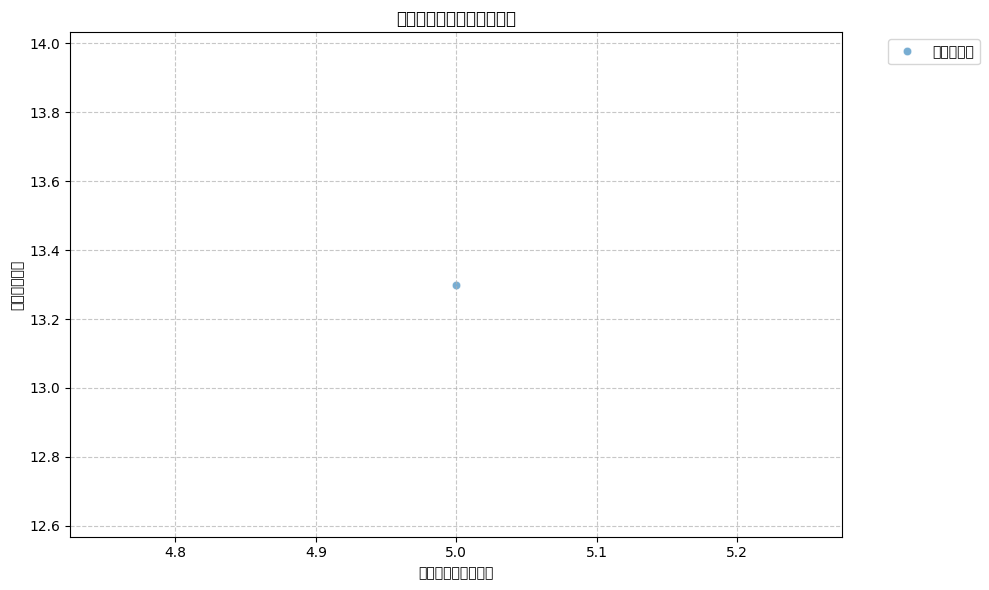

/var/folders/33/_hgbk85d5f90ql149mhsrv0h0000gn/T/ipykernel_16148/3993004954.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='distance_group', y='rent', palette='Set2')
findfont: Font family 'MS Gothic' not found.
findfont: Font family 'MS Gothic' not found.
findfont: Font family 'MS Gothic' not found.
findfont: Font family 'MS Gothic' not found.
findfont: Font family 'MS Gothic' not found.
findfont: Font family 'MS Gothic' not found.
findfont: Font family 'MS Gothic' not found.
findfont: Font family 'MS Gothic' not found.
findfont: Font family 'MS Gothic' not found.
findfont: Font family 'MS Gothic' not found.
/Users/masashi/dsprog/ds2/DSPROG2_2025/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 23478 (\N{CJK UNIFIED IDEOGRAPH-5BB6}) missing from font(s) DejaVu Sans.
  fig.canvas.prin

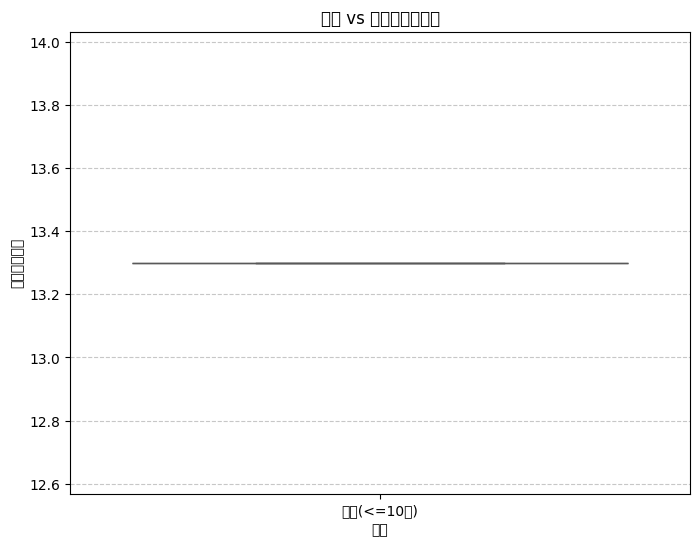

In [ ]:
# 1. 散布図：駅距離 vs 家賃
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='station_distance', y='rent', hue='floor_plan', alpha=0.6)
plt.title('駅からの距離と家賃の関係', fontsize=16)
plt.xlabel('駅からの距離（分）', fontsize=12)
plt.ylabel('家賃（万円）', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title='間取り')
plt.tight_layout()
plt.show()

# 2. 箱ひげ図：駅近 vs 駅遠
df['distance_group'] = df['station_distance'].apply(lambda x: '駅近(<=10分)' if x <= 10 else '駅遠(>10分)')
plt.figure(figsize=(8, 6))
sns.boxplot(data=df, x='distance_group', y='rent', palette='Set2')
plt.title('駅近 vs 駅遠の家賃分布', fontsize=16)
plt.xlabel('区分', fontsize=12)
plt.ylabel('家賃（万円）', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()
